Calculate input proportion (i.e. inprop, normalised connectivity) for all of FAFB on a signle neuron level.

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import scipy as sp
import matplotlib.pyplot as plt

# reading data

In [2]:
info = pd.read_csv(
    "https://raw.githubusercontent.com/flyconnectome/flywire_annotations/main/supplemental_files/Supplemental_file1_neuron_annotations.tsv",
    delimiter="\t",
)
root_to_super_class = dict(zip(info["root_id"], info["super_class"]))
info.columns

C:\Users\44745\AppData\Local\Temp\ipykernel_10488\847433904.py:1: DtypeWarning: Columns (14,15,16,17,23) have mixed types. Specify dtype option on import or set low_memory=False.
  info = pd.read_csv(


Index(['supervoxel_id', 'root_id', 'pos_x', 'pos_y', 'pos_z', 'soma_x',
       'soma_y', 'soma_z', 'nucleus_id', 'flow', 'super_class', 'cell_class',
       'cell_sub_class', 'cell_type', 'hemibrain_type', 'ito_lee_hemilineage',
       'hartenstein_hemilineage', 'morphology_group', 'top_nt', 'top_nt_conf',
       'known_nt', 'known_nt_source', 'side', 'nerve', 'vfb_id', 'fbbt_id',
       'status'],
      dtype='object')

In [3]:
# read matslia cell types, downloaded from here:
# https://codex.flywire.ai/api/download

matslia = pd.read_csv(
    "C:/Users/44745/Downloads/visual_neuron_types.csv.gz", compression="gzip"
)
matslia["super_class"] = matslia.root_id.map(root_to_super_class)

matslia_root_to_type = dict(zip(matslia.root_id, matslia.type))
matslia

,root_id,type,family,subsystem,category,side,super_class
0,720575940596125868,T5c,T5 Neuron,Motion,intrinsic,right,optic
1,720575940597856265,Tm16,Transmedullary,Color,intrinsic,right,optic
2,720575940597944841,Tm7,Transmedullary,Color,intrinsic,right,optic
3,720575940598267657,TmY15,Transmedullary Y,Object,intrinsic,right,optic
4,720575940599333574,Tm1,Transmedullary,OFF,intrinsic,right,optic
...,...,...,...,...,...,...,...
95152,720575940661323905,L4,Lamina Monopolar,OFF,intrinsic,left,optic
95153,720575940661325697,MTe07,MT,NaN,boundary,left,visual_projection
95154,720575940661327745,LTe09,LT,NaN,boundary,right,visual_projection
95155,720575940661336193,TmY3,Transmedullary Y,Object,intrinsic,left,optic


In [4]:
matslia.super_class.value_counts()

super_class
optic                 76780
sensory                9699
visual_projection      8028
visual_centrifugal      499
central                 128
descending               14
ascending                 9
Name: count, dtype: int64

In [5]:
matslia.subsystem.value_counts(dropna=False)

subsystem
Motion            15614
Color             15260
Object            14804
OFF               11046
ON                 9916
Photoreceptors     9777
NaN                8444
Luminance          6430
Form               3713
Polarization        153
Name: count, dtype: int64

In [6]:
info.super_class.value_counts(dropna=False)

super_class
optic                 77536
central               32388
sensory               16903
visual_projection      8053
ascending              2362
descending             1303
visual_centrifugal      524
motor                   106
endocrine                80
Name: count, dtype: int64

## make combined cell type

In [7]:
# where are the cell types?
info[["cell_type", "hemibrain_type"]].isna().value_counts()

cell_type  hemibrain_type
False      True              102047
True       False              20721
False      False               9043
True       True                7444
Name: count, dtype: int64

In [8]:
# around 3k with both cell_type and hemibrain_type - do they correspond to each other?
info[~info.cell_type.isna() & ~info.hemibrain_type.isna()][
    ["cell_type", "hemibrain_type"]
].value_counts()

cell_type   hemibrain_type                                                         
KCab        KCab-s                                                                     621
            KCab-m                                                                     619
            KCab-c                                                                     403
KCapbp-m    KCa'b'-m                                                                   338
KCapbp-ap2  KCa'b'-ap2                                                                 298
                                                                                      ... 
LCe01b      LC25                                                                         1
            LC25,LC26                                                                    1
CB.FB3,4I1  FB4A,FB4D,FB4E,FB4F,FB4G,FB4H,FB4I,FB4J                                      1
CB.FB3,4D4  FB5X                                                                         1
vDelta

In [9]:
# use matslia cell types for optic lobe intrinsic neurons
info.loc[info.super_class == "optic", ["combined_type"]] = info.loc[
    info.super_class == "optic", "root_id"
].map(matslia_root_to_type)
# matslia optic lobe cell type > cell type > hemibrain type > root id
info.combined_type.fillna(info.cell_type, inplace=True)
info.combined_type.fillna(info.hemibrain_type, inplace=True)
info.combined_type.fillna(info.root_id.astype(str), inplace=True)

C:\Users\44745\AppData\Local\Temp\ipykernel_10488\1846059608.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['LC14a1', 'LC14a1', nan, 'l-LNv', 'LC14a2', 'LC14b', 'MeMe_e09', nan, nan, 'LC14b', 'LC14a2', 'LC14a1', 'LC14a1', 'LC14a2', 'LC14a1', 'LC14b', 'LC14a1', 'l-LNv', 'LC14a1', 'LC14a1', nan, 'MeMe_e02', nan, 'LC14b', 'LC14a1', 'MeMe_e10', nan, 'LC14a2', 'LC14a1', 'MeLp2', 'LC14a2', 'LC14a1', 'MeMe_e01', 'LC14b', 'MeMe_e10', 'MeMe_e11', 'LC14a2', 'LC14a2', 'MeMe_e01', 'LC14b', 'LC14a2', 'LC14a2', 'LC14a2', 'LC14a1', 'LC14a1', 'LC14b', 'LC14a1', 'LC14a1', 'LC14a1', 'LC14a1', 'LC14a1', 'LC14a1', 'LC14a2', 'LC14a1', 'LC14b', 'LC14a1', 'LC14b', 'LC14a2', 'LC14a1', 'LC14b', 'LC14a1', 'MeMe_e01', 'LC14a1', 'LC14a2', 'LC14a2', nan, 'LC14b', nan, 'LC14a2', 'LC14a2', 'LC14a1', 'LC14a2', 'LC14b', 'LC14b', 'LC14a2', 'LC14b', 'LC14b', nan, 'LC14a1', 'LC14b', 'LC14b', 'LC14b', 'LC14b', 'LC14a2', 'LC14a2', 'LC14b', 'LC14b

In [10]:
# make dictionaries to map between columns
typedict = dict(zip(info.root_id, info.combined_type))
sidedict = dict(zip(info.root_id, info.side))
type_super_class_dict = dict(zip(info.combined_type, info.super_class))
type_class_dict = dict(zip(info.combined_type, info.cell_class))
type_sub_class_dict = dict(zip(info.combined_type, info.cell_sub_class))

## read connectivity
Courtesy of Dr Sven Dorkenwald: https://zenodo.org/records/10676866

In [11]:
# this can take a minute or two
from io import BytesIO
import requests

url = "https://zenodo.org/records/10676866/files/proofread_connections_783.feather"

# Download the file
response = requests.get(url)

# Use the file content directly in Python
file_content = response.content

conn_full = pd.read_feather(BytesIO(file_content))
conn_full

,pre_pt_root_id,post_pt_root_id,neuropil,syn_count,gaba_avg,ach_avg,glut_avg,oct_avg,ser_avg,da_avg
0,720575940629970489,720575940631267655,AVLP_R,7,0.654330,0.023704,2.724177e-01,4.812546e-02,4.724386e-04,0.000951
1,720575940623828999,720575940612348950,SLP_R,4,0.386517,0.024020,5.805122e-01,8.166312e-04,8.567505e-04,0.007278
2,720575940624078484,720575940616950161,SMP_R,2,0.001719,0.979256,1.810526e-03,1.633383e-05,5.870429e-03,0.011328
3,720575940629583345,720575940620324735,SMP_L,2,0.011815,0.031954,4.729873e-01,9.134340e-03,8.697341e-02,0.387136
4,720575940605876866,720575940606514878,LAL_R,15,0.994271,0.005063,5.223293e-04,3.998458e-07,1.034742e-04,0.000040
...,...,...,...,...,...,...,...,...,...,...
16847992,720575940615769750,720575940622822680,AVLP_L,1,0.004619,0.896132,3.206258e-02,1.844075e-03,2.894549e-02,0.036396
16847993,720575940624016823,720575940622760993,ME_R,4,0.080482,0.536168,2.336121e-02,3.442164e-01,2.744474e-04,0.015498
16847994,720575940637397309,720575940633255123,SLP_R,2,0.987325,0.008161,4.205040e-03,8.760364e-06,2.006123e-05,0.000281
16847995,720575940636432014,720575940617470681,ME_R,1,0.026646,0.031076,9.088086e-01,4.470230e-03,1.418527e-02,0.014815


In [12]:
conn_full.loc[:, ["pre_type"]] = conn_full.pre_pt_root_id.map(typedict)
conn_full.loc[:, ["post_type"]] = conn_full.post_pt_root_id.map(typedict)
conn_full.loc[:, ["pre_side"]] = conn_full.pre_pt_root_id.map(sidedict)
conn_full.loc[:, ["post_side"]] = conn_full.post_pt_root_id.map(sidedict)
conn_full.loc[:, ["pre_super_class"]] = conn_full.pre_type.map(type_super_class_dict)
conn_full.loc[:, ["post_super_class"]] = conn_full.post_type.map(type_super_class_dict)
conn_full

,pre_pt_root_id,post_pt_root_id,neuropil,syn_count,gaba_avg,ach_avg,glut_avg,oct_avg,ser_avg,da_avg,pre_type,post_type,pre_side,post_side,pre_super_class,post_super_class
0,720575940629970489,720575940631267655,AVLP_R,7,0.654330,0.023704,2.724177e-01,4.812546e-02,4.724386e-04,0.000951,PLP017,CB3488,right,right,central,central
1,720575940623828999,720575940612348950,SLP_R,4,0.386517,0.024020,5.805122e-01,8.166312e-04,8.567505e-04,0.007278,LHPV6p1,AVLP314,right,right,central,central
2,720575940624078484,720575940616950161,SMP_R,2,0.001719,0.979256,1.810526e-03,1.633383e-05,5.870429e-03,0.011328,CB0960,CB0710,left,right,central,central
3,720575940629583345,720575940620324735,SMP_L,2,0.011815,0.031954,4.729873e-01,9.134340e-03,8.697341e-02,0.387136,CB0960,CB2317,left,left,central,central
4,720575940605876866,720575940606514878,LAL_R,15,0.994271,0.005063,5.223293e-04,3.998458e-07,1.034742e-04,0.000040,LAL138,CB2018,left,right,central,central
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16847992,720575940615769750,720575940622822680,AVLP_L,1,0.004619,0.896132,3.206258e-02,1.844075e-03,2.894549e-02,0.036396,PVLP007,AVLP089,left,left,central,central
16847993,720575940624016823,720575940622760993,ME_R,4,0.080482,0.536168,2.336121e-02,3.442164e-01,2.744474e-04,0.015498,TmY10,TmY4,right,right,optic,optic
16847994,720575940637397309,720575940633255123,SLP_R,2,0.987325,0.008161,4.205040e-03,8.760364e-06,2.006123e-05,0.000281,CB2036,CB1594,right,right,central,central
16847995,720575940636432014,720575940617470681,ME_R,1,0.026646,0.031076,9.088086e-01,4.470230e-03,1.418527e-02,0.014815,Mi14,Tm2,right,right,optic,optic


In [13]:
allids = set(conn_full.pre_pt_root_id) | set(conn_full.post_pt_root_id)
len(allids)

138639

In [14]:
# check to make sure
meta = info[info.root_id.isin(allids)]

In [15]:
# number of GB
len(allids) ** 2 * 4 / 1e9

76.883089284

# NT

In [16]:
meta.top_nt.value_counts(dropna=False)

top_nt
acetylcholine    86028
glutamate        24865
gaba             19150
dopamine          5905
serotonin         2201
NaN                280
octopamine         210
Name: count, dtype: int64

In [17]:
meta.known_nt.unique()

array([nan, 'acetylcholine', 'DILP2, DILP3, DILP5', 'glutamate',
       'glutamate, sparkly, proctolin, Nplp1',
       'dopamine, sparkly, Nplp1, amnesiac, CG43117, ion-transport peptide, nitric oxide',
       'gaba', 'acetylcholine, Nplp1, sNPF, sparkly',
       'glutamate, Dh44, allatostatin-c', 'dopamine',
       'acetylcholine, sNPF, sparkly', 'Dh44', 'octopamine',
       'acetylcholine, sparkly',
       'dopamine, amnesiac, sparkly, Nplp1, CG34136, sNPF', 'CCHa2R',
       'Drosulfakinin', 'gaba, myoinhibitory peptide',
       'dopamine, Nplp1, sNPF, sparkly, amnesiac, CG34136',
       'dopamine, amnesiac, sparkly, Dh44, CG34136, Nplp1',
       'allatostatin-a, glutamate', 'CCHa1, Dh44, glutamate',
       'dopamine, amnesiac, sparkly, pdf, Gpb5', 'Dh31',
       'acetylcholine, space blanket',
       'gaba, serotonin, sparkly, Nplp1, proctolin, orcokinin, eclosion hormone, CG34136',
       'serotonin', 'glycine, pdf', 'dopamine, nitric oxide',
       'glutamate, leucokinin', 'corazo

In [18]:
# known_nt takes priority
meta["known_nt_simplified"] = meta.known_nt
# pattern matching: only keep if value contains 'glutamate', 'gaba', or 'acetylcholine'
meta.known_nt_simplified = meta.known_nt_simplified.str.extract(
    "(glutamate|gaba|acetylcholine)", expand=False
)
# note that if a value has multiple matches, only the first one is kept
# e.g. 'glutamate, gaba' will be simplified to 'glutamate'
meta.known_nt_simplified.value_counts(dropna=False)

# then use this column to replace values in top_nt column
meta.top_nt = meta.known_nt_simplified.fillna(meta.top_nt)

C:\Users\44745\AppData\Local\Temp\ipykernel_10488\316772857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta["known_nt_simplified"] = meta.known_nt
C:\Users\44745\AppData\Local\Temp\ipykernel_10488\316772857.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta.known_nt_simplified = meta.known_nt_simplified.str.extract(
C:\Users\44745\AppData\Local\Temp\ipykernel_10488\316772857.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

C:\Users\44745\AppData\Local\Temp\ipykernel_10488\4061033137.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta["top_nt"] = meta["top_nt"].fillna("unknown")


(array([9.474e+03, 5.810e+02, 0.000e+00, 8.900e+01, 0.000e+00, 2.000e+01,
        4.000e+00, 0.000e+00, 5.000e+00, 6.000e+00]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

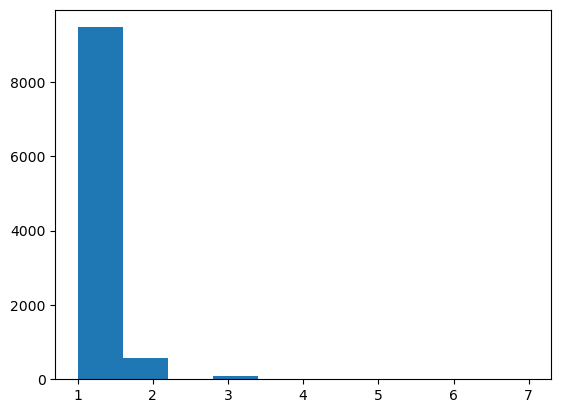

In [19]:
# first check consistency of NT within each type
meta["top_nt"] = meta["top_nt"].fillna("unknown")
nt_count_per_type = meta.groupby("combined_type")["top_nt"].nunique()
plt.hist(nt_count_per_type)

In [20]:
# For those with different NT for each neuron, get the majority NT for each type
nt_conflict_types = nt_count_per_type[nt_count_per_type > 1].index

# Getting counts of top_nt for each combined_type
nt_conflict_type_counts = (
    meta[meta.combined_type.isin(nt_conflict_types)]
    .groupby(["combined_type", "top_nt"])
    .size()
)

# Convert the series to a DataFrame and reset index
nt_conflict_type_counts = nt_conflict_type_counts.reset_index(name="counts")

# Sort by combined_type and counts in descending order
nt_conflict_type_counts.sort_values(
    by=["combined_type", "counts"], ascending=[True, False], inplace=True
)

# Initialize dictionary with existing type-nt matching
type_nt = dict(zip(meta.combined_type, meta.top_nt))
# Initialize a list to keep track of types with equal top_nt counts
types_with_equal_top_nt_counts = []


# Custom function to handle ties, random selection, and record keeping
def select_random_nt_and_record_ties(df):
    max_count = df["counts"].max()
    top_nts = df[df["counts"] == max_count]
    if len(top_nts) > 1:  # If there are ties
        types_with_equal_top_nt_counts.append(
            df["combined_type"].iloc[0]
        )  # Record the type with ties
        random_nt = np.random.choice(top_nts["top_nt"].values)
        while random_nt == "unknown":
            random_nt = np.random.choice(top_nts["top_nt"].values)
        return random_nt  # Random selection among ties
    else:
        return top_nts["top_nt"].values[0]


# Loop through each type to get the top_nt, handling ties appropriately
for atype in nt_conflict_types:
    type_df = nt_conflict_type_counts[nt_conflict_type_counts["combined_type"] == atype]
    top_nt = select_random_nt_and_record_ties(type_df)
    type_nt[atype] = top_nt

len(types_with_equal_top_nt_counts)

238

In [21]:
types_with_equal_top_nt_counts

['5-HTPMPV01',
 'AL-MBDL1',
 'ALBN1',
 'AN_AVLP_38',
 'AN_AVLP_GNG_12',
 'AN_FLA_GNG_2',
 'AN_GNG_1',
 'AN_GNG_102',
 'AN_GNG_104',
 'AN_GNG_106',
 'AN_GNG_116',
 'AN_GNG_121',
 'AN_GNG_123',
 'AN_GNG_125',
 'AN_GNG_130',
 'AN_GNG_137',
 'AN_GNG_177',
 'AN_GNG_20',
 'AN_GNG_202',
 'AN_GNG_31',
 'AN_GNG_34',
 'AN_GNG_48',
 'AN_GNG_62',
 'AN_GNG_77',
 'AN_GNG_90',
 'AN_GNG_95',
 'AN_GNG_IPS_1',
 'AN_GNG_IPS_5',
 'AN_GNG_PRW_3',
 'AN_GNG_SAD_7',
 'AN_IPS_GNG_1',
 'AN_IPS_GNG_5',
 'AN_SAD_FLA_1',
 'AN_SLP_AVLP_1',
 'AN_SMP_3',
 'AN_SMP_FLA_1',
 'AN_multi_11',
 'AN_multi_77',
 'AN_multi_87',
 'AN_multi_89',
 'AOTU024',
 'AOTU036',
 'ATL021',
 'ATL030',
 'ATL034',
 'AVLP031',
 'AVLP048',
 'AVLP155',
 'AVLP213',
 'AVLP215',
 'AVLP219a',
 'AVLP394',
 'BM_dOcci',
 'CAPA',
 'CB.FB3,4I2',
 'CB.FB3,4I8',
 'CB.FB6C3',
 'CB.FB6I1',
 'CB0019',
 'CB0034',
 'CB0090',
 'CB0124',
 'CB0155',
 'CB0176',
 'CB0189',
 'CB0224',
 'CB0235',
 'CB0262',
 'CB0265',
 'CB0279',
 'CB0289',
 'CB0369',
 'CB0446',
 'CB0

In [22]:
# the types without any known nt
[atype for atype, nt in type_nt.items() if nt == "unknown"]

['720575940638707901',
 'DNge061',
 '720575940612376690',
 '720575940624156391',
 '720575940632738259',
 '720575940621636988',
 '720575940610239608',
 '720575940623382711',
 '720575940612269283',
 'AN_GNG_204',
 '720575940635901274',
 '720575940619617919',
 '720575940639152117',
 '720575940625771780',
 '720575940624211202',
 '720575940628628055',
 '720575940618759078',
 '720575940629273130',
 '720575940628268226',
 '720575940620287820',
 '720575940615072662',
 '720575940625760816',
 '720575940612070769',
 '720575940610241860',
 '720575940638619214',
 '720575940627099934',
 '720575940628125416']

In [23]:
# update the top_nt column to be consistent within each type
meta.loc[:, ["top_nt"]] = meta.combined_type.map(type_nt)
meta

,supervoxel_id,root_id,pos_x,pos_y,pos_z,soma_x,soma_y,soma_z,nucleus_id,flow,...,top_nt_conf,known_nt,known_nt_source,side,nerve,vfb_id,fbbt_id,status,combined_type,known_nt_simplified
0,78112261444987077,720575940628857210,109306,50491,3960,104904.0,47464.0,5461.0,2453924.0,intrinsic,...,0.917977,NaN,NaN,left,NaN,fw138205,FBbt_20001935,NaN,PS180,NaN
1,82475466912542440,720575940626838909,172029,55635,1592,177472.0,56936.0,1429.0,7393349.0,intrinsic,...,0.645442,NaN,NaN,right,NaN,fw000001,NaN,NaN,CB0924,NaN
2,83038623024880664,720575940626046919,180632,58664,1925,180632.0,58664.0,1925.0,7415038.0,intrinsic,...,0.844781,NaN,NaN,right,NaN,fw000002,FBbt_20000538,NaN,AVLP429,NaN
3,79801523353604463,720575940630311383,133800,56063,1847,180728.0,61008.0,1630.0,7415013.0,intrinsic,...,0.760387,NaN,NaN,right,NaN,fw000003,FBbt_20000260,NaN,AVLP151,NaN
4,83038554439606237,720575940633370649,180496,57448,2989,180496.0,57448.0,2989.0,7415848.0,intrinsic,...,0.895458,NaN,NaN,right,NaN,fw000004,FBbt_00051248,NaN,LC27,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139250,83038485720179477,720575940618571494,181000,56672,3032,181000.0,56672.0,3032.0,7667349.0,intrinsic,...,0.909508,NaN,NaN,right,NaN,fw019880,NaN,NaN,720575940618571494,NaN
139251,81632416707449383,720575940633170572,160568,75600,4130,160568.0,75600.0,4130.0,6918265.0,intrinsic,...,0.842339,NaN,NaN,right,NaN,fw002173,NaN,outlier_bio,Li02,NaN
139252,81702991543049294,720575940650339961,161088,79280,3677,161088.0,79280.0,3677.0,6918344.0,intrinsic,...,0.927558,NaN,NaN,right,NaN,fw010095,NaN,outlier_bio,Li02,NaN
139253,75720205111813659,720575940619997854,74280,57640,3166,74280.0,57640.0,3166.0,1511338.0,intrinsic,...,0.897331,NaN,NaN,left,NaN,fw046509,NaN,NaN,MTe51,NaN


In [24]:
# for now regarding everything (ACh, Glu, GABA, Dopamine, Serotonine, ??) except for Glu and GABA to be excitatory
# first make a dictionary
nt_value = {
    "acetylcholine": 1,
    "glutamate": -1,
    "gaba": -1,
    "dopamine": 1,
    "serotonin": 1,
    "octopamine": 1,
    "unknown": 1,
}

# make coo

In [25]:
# sum synapse numbers across neuropils
conn = (
    conn_full.groupby(["pre_pt_root_id", "post_pt_root_id"])
    .syn_count.sum()
    .reset_index()
)
conn

,pre_pt_root_id,post_pt_root_id,syn_count
0,720575940596125868,720575940605825666,2
1,720575940596125868,720575940606217138,1
2,720575940596125868,720575940608552405,5
3,720575940596125868,720575940609975854,4
4,720575940596125868,720575940613059993,5
...,...,...,...
15091978,720575940661338497,720575940643867296,1
15091979,720575940661338497,720575940645527918,1
15091980,720575940661338497,720575940647030580,1
15091981,720575940661339777,720575940616982614,4


In [26]:
# instead of making a dense matrix based on the edgelist above, let's make a sparse one from the edgelist directly
# first make a coo matrix
nodes = set(conn.pre_pt_root_id).union(set(conn.post_pt_root_id))
sorted_nodes = sorted(nodes)  # Convert the set to a sorted list
nodes_to_idx = {node: num for num, node in enumerate(sorted_nodes)}

# type to type connectivity
conn["pre_idx"] = conn.pre_pt_root_id.map(nodes_to_idx)
conn["post_idx"] = conn.post_pt_root_id.map(nodes_to_idx)

# Create COO matrix
row = conn["pre_idx"].values
col = conn["post_idx"].values
data = conn["syn_count"].values
matrix_size = len(nodes)
coo = coo_matrix((data, (row, col)), shape=(matrix_size, matrix_size))

# then turn it into csc matrix
csc = coo.tocsc()

# calculate the size
csc_size = csc.data.nbytes  # Size of the data array
csc_size += csc.indices.nbytes  # Size of the indices array
csc_size += csc.indptr.nbytes  # Size of the index pointer array
# number of MB
csc_size / 1e6

181.658356

In [27]:
csc.shape

(138639, 138639)

In [28]:
csc

<138639x138639 sparse matrix of type '<class 'numpy.int64'>'
	with 15091983 stored elements in Compressed Sparse Column format>

In [29]:
# calculate the total post-synapses for each neuron
total_post = (
    conn_full[conn_full.post_pt_root_id.isin(nodes)]
    .groupby("post_pt_root_id")
    .syn_count.sum()
)

# some neurons have no postsynapses (receptors). Let's add those to total_post with value of 0
no_post = nodes - set(total_post.index)
no_post_dict = dict(zip(no_post, np.zeros(len(no_post), dtype=int)))
total_post = pd.concat([total_post, pd.Series(no_post_dict)])
total_post

720575940596125868    151
720575940597856265    435
720575940597944841    276
720575940598267657    836
720575940599333574    385
                     ... 
720575940612956122      0
720575940642381787      0
720575940634435553      0
720575940625391595      0
720575940653400054      0
Length: 138639, dtype: int64

In [30]:
# re-order so that it matches order of nodes
total_post = total_post.loc[sorted_nodes]
total_post

720575940596125868     151
720575940597856265     435
720575940597944841     276
720575940598267657     836
720575940599333574     385
                      ... 
720575940661335681     683
720575940661336193     614
720575940661337217     198
720575940661338497    2397
720575940661339777       2
Length: 138639, dtype: int64

In [31]:
# Handling division by zero in case some columns have a sum of zero
# that is, where a neuron doesn't have incoming synapses
col_sums_with_inversion = np.reciprocal(
    total_post.to_numpy().astype(float), where=total_post.to_numpy() != 0
)
# Multiply each column by the inverse of its sum
inprop = csc.multiply(col_sums_with_inversion)
# and then reduce the precision to float32 to save memory
inprop = inprop.astype(np.float32)

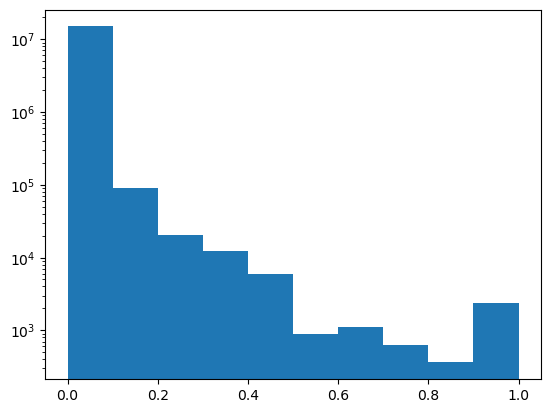

In [32]:
# histogram of connection strengths
plt.hist(inprop.data)
plt.yscale("log")
plt.show()

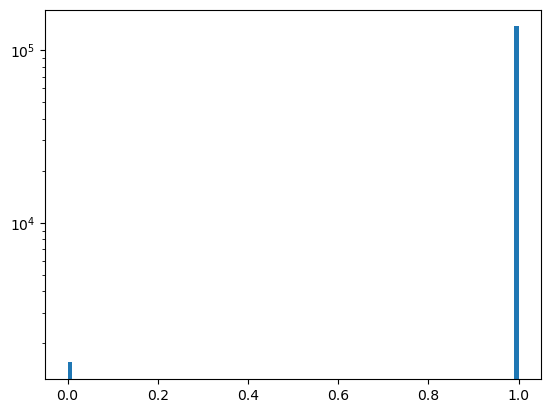

In [33]:
# histogram of column sums
colsums = inprop.sum(axis=0)
plt.hist(colsums.A1, bins=100)
plt.yscale("log")
plt.show()

In [34]:
# how many colsums are around 1?
np.sum(colsums > 0.99)

137090

In [35]:
sp.sparse.save_npz(
    "../data/fafb_all_neuron/fafb_inprop_all_neuron.npz",
    inprop,
)

# save meta

In [36]:
# save to csv, one row is one neuron
meta = meta.loc[
    meta.root_id.isin(nodes),
    [
        "root_id",
        "combined_type",
        "side",
        "top_nt",
        "super_class",
        "cell_class",
        "cell_sub_class",
    ],
]
meta.loc[:, ["idx"]] = meta.root_id.map(nodes_to_idx)
meta.loc[:, ["sign"]] = meta.top_nt.map(nt_value)
meta.rename(columns={"combined_type": "cell_type"}, inplace=True)

# adult, right hemisphere, neuron level, meta information
meta.to_csv(f"../data/fafb_all_neuron/fafb_all_neuron_meta.csv")

In [37]:
meta

,root_id,cell_type,side,top_nt,super_class,cell_class,cell_sub_class,idx,sign
0,720575940628857210,PS180,left,acetylcholine,central,NaN,NaN,90602,1
1,720575940626838909,CB0924,right,acetylcholine,central,NaN,NaN,78651,1
2,720575940626046919,AVLP429,right,acetylcholine,central,NaN,NaN,74602,1
3,720575940630311383,AVLP151,right,acetylcholine,central,NaN,NaN,98019,1
4,720575940633370649,LC27,right,acetylcholine,visual_projection,NaN,NaN,112255,1
...,...,...,...,...,...,...,...,...,...
139250,720575940618571494,720575940618571494,right,acetylcholine,optic,ME>LO,NaN,35687,1
139251,720575940633170572,Li02,right,acetylcholine,optic,LO,NaN,111463,1
139252,720575940650339961,Li02,right,acetylcholine,optic,LO,NaN,136780,1
139253,720575940619997854,MTe51,left,acetylcholine,optic,ME>LO,NaN,41368,1
